# Forward & Inverse modelling 2D ERT with pyGimli

Here we take a look at forward modelling a layered earth, then inverting the forward modelling result first without
constraints, then with some layer definitions. With much thanks to the folks behind [pyGimli](https://www.pygimli.org/).

First, load up some packages. We need to have pygimli & numpy in addition to standard python installation, and reference
the exampledata folder if we want to pick up field data for electrode configurations.

In [2]:
import pygimli as pg
import numpy as np
from pygimli.physics import ert
import pygimli.meshtools as mt

datafolder = "..\\exampledata\\Lubango\\"

## Create the electrode scheme and model

Firstly, create a 'scheme' of electrode locations to integrate into the world mesh later.

Options below show the code for firstly a simulated 21-point dipole-dipole (`dd`) array of electrodes every 5m from `x=0` to `x=100`.

Alternately, we can load example data, and take the electrode locations from there.

Other preset configurations include Wenner, `'wa'`, Schlumberger `'slm'` and pole-dipole `'pd'`. To trigger a list, run the
cell with the `schemeName` set to an unrecognised scheme, e.g. `'abc'`.\

In [4]:
# Option to create 'synthetic' electrode scheme
# elecs=np.linspace(start=0, stop=100, num=21)

# Option to use scheme from field data...
data = ert.load(datafolder+"DD_5-1.ohm") 
elecs=pg.x(data)

scheme = ert.createData(elecs=elecs, schemeName='dd')

print(scheme['a'])


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38  0  1  2  3  4  5  6  7  8
  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32
 33 34 35 36 37  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18
 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36  0  1  2  3  4  5
  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
 30 31 32 33 34 35  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17
 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34  0  1  2  3  4  5  6
  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20
 21 22 23 24 25 26 27 28 29 30 31 32  0  1  2  3  4  5  6  7  8  9 10 11
 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31  0  1  2  3
  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30  0  1  2  3  4  5  6  7  8  9 10 11 12 13

Next, create a 'world' (with optional layers, bodies, etc) and display it. This currently creates a 'world' with limits based on the `elecs` variable above, with 2 layers at 2m and 10m depth overlying a halfspace.

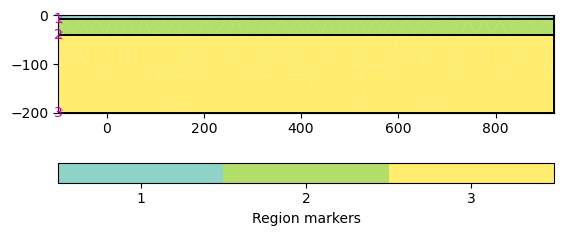

In [5]:
spacing = (max(elecs) - min(elecs))/(len(elecs) -1)

world = mt.createWorld(start=[min(elecs)-5*spacing, 0.], 
                       end=[max(elecs)+5*spacing, -10*spacing],
                       layers=[-0.4*spacing, -2*spacing], worldMarker=True)
pg.show(world);

It's also possible to define circles, rectangles and polygons with the pygimli meshtools, then add them to the 'world' 
arithmetically, e.g. `world += block`. Full details of arguments at [pygimli.meshtools](https://www.pygimli.org/pygimliapi/_generated/pygimli.meshtools.html#module-pygimli.meshtools)

Some examples:
```
ball = mt.createCircle(pos=[25, -3.], radius=[4, 1], marker=4, boundaryMarker=10, area=0.1)

poly = mt.createPolygon([(11,-4), (12,-1.5), (14,-2), (15,-2), (18,-3), (15,-3.5), (13,-4.5)],
                        isClosed=True, addNodes=3, interpolate='spline', marker=5)
                        
block = mt.createRectangle(start = [55,-4], end = [60,-10], marker=6)
```

## Create mesh for earth model & electrode locations

Next, create the mesh within the 'world' for the earth model. The electrode scheme defines nodes in the mesh (with additional
nodes at 1/10 spacing on recommendations from pyGimli devs). We then define a resistivity mapping for the three layers, and 
display the model.

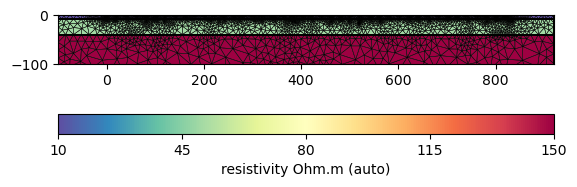

In [6]:
for p in scheme.sensors():
    world.createNode(p)
    world.createNode(p - [0, 0.1])

mesh = mt.createMesh(world, quality=34)

rhomap = [[1,10.],[2,50.],[3,150.]]

ax, _ = pg.show(mesh, data=rhomap, label=pg.unit('resistivity Ohm.m'),
                showMesh=True, cMap="Spectral_r")
ax.set_ylim(-5*spacing,0);

## Run the forward model & display result

12/06/24 - 17:31:30 - pyGIMLi - INFO - Data error estimate (min:max)  0.010021095734555332 : 0.04119774555004165
12/06/24 - 17:31:30 - pyGIMLi - INFO - 0.44159867261511065 2086.694265729293
12/06/24 - 17:31:30 - pyGIMLi - INFO - Simulated data Data: Sensors: 42 data: 780, nonzero entries: ['a', 'b', 'err', 'k', 'm', 'n', 'rhoa', 'valid']
12/06/24 - 17:31:30 - pyGIMLi - INFO - The data contains: ['a', 'b', 'err', 'i', 'ip', 'iperr', 'k', 'm', 'n', 'r', 'rhoa', 'u', 'valid']


relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100


12/06/24 - 17:31:30 - pyGIMLi - INFO - Simulated rhoa (min/max) 17.308582673175213 130.89797142125263
12/06/24 - 17:31:30 - pyGIMLi - INFO - Selected data noise %(min/max) 1.0021095734555332 4.119774555004165


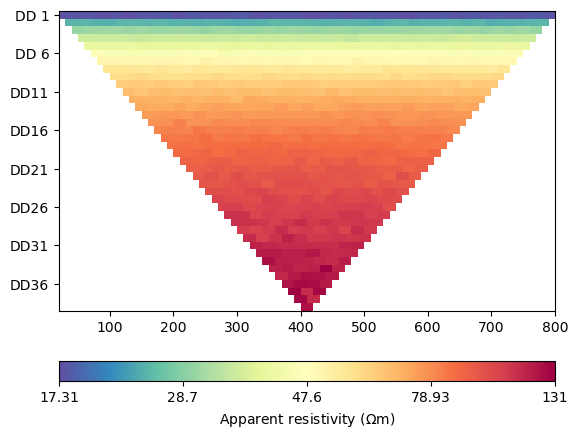

In [7]:
fwddata = ert.simulate(mesh, scheme=scheme, res=rhomap, noiseLevel=1,
                    noiseAbs=1e-6, seed=1337);

# set information fields
pg.info(np.linalg.norm(fwddata['err']), np.linalg.norm(fwddata['rhoa']));
pg.info('Simulated data', fwddata);
pg.info('The data contains:', fwddata.dataMap().keys());

pg.info('Simulated rhoa (min/max)', min(fwddata['rhoa']), max(fwddata['rhoa']));
pg.info('Selected data noise %(min/max)', min(fwddata['err'])*100, max(fwddata['err'])*100);

ert.show(fwddata);

In [33]:
print(fwddata['a'][39],fwddata['b'][39],fwddata['m'][39],fwddata['n'][39])
print(fwddata['a'],'\n', fwddata['m'])

0 1 3 4
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38  0  1  2  3  4  5  6  7  8
  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32
 33 34 35 36 37  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18
 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36  0  1  2  3  4  5
  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
 30 31 32 33 34 35  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17
 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34  0  1  2  3  4  5  6
  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20
 21 22 23 24 25 26 27 28 29 30 31 32  0  1  2  3  4  5  6  7  8  9 10 11
 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31  0  1  2  3
  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30  0  1  2  3  4  5  6  7  8  9 10 

780 [-376.99111843077515,...,-4018725.3224727185]


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x222d0310f10>)

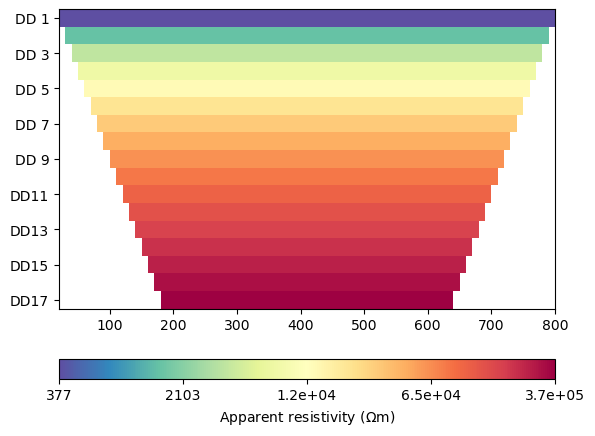

In [22]:
print(fwddata['k'])
fwddata.remove(-fwddata['k'] > 400000)
ert.show(fwddata, -fwddata['k'], logScale=True)

## Run inversion of forward modelled output

First inversion test is completely open with automated mesh definition, and no constraints.

12/06/24 - 17:42:41 - pyGIMLi - INFO - Found 2 regions.
12/06/24 - 17:42:41 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
12/06/24 - 17:42:41 - pyGIMLi - INFO - Found 2 regions.
12/06/24 - 17:42:41 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
12/06/24 - 17:42:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
12/06/24 - 17:42:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
12/06/24 - 17:42:41 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 1936 Cells: 3628 Boundaries: 2842
12/06/24 - 17:42:41 - pyGIMLi - INFO - Use median(data values)=54.913818253728984
12/06/24 - 17:42:41 - pyGIMLi - INFO - Created startmodel from forward operator: 680, min/max=54.913818/54.913818
12/06/24 - 17:42:41 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000222D0535C10>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x00000222B0D2A2F0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000222BD4D6C50>
min/max (data): 17.31/87.04
min/max (error): 1%/1.44%
min/max (start model): 54.91/54.91
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 2067.13
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =  260.19 (dPhi = 87.37%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   14.80 (dPhi = 93.48%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    1.28 (dPhi = 78.70%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    1.12 (dPhi = 4.71%) lam: 20.0
----------

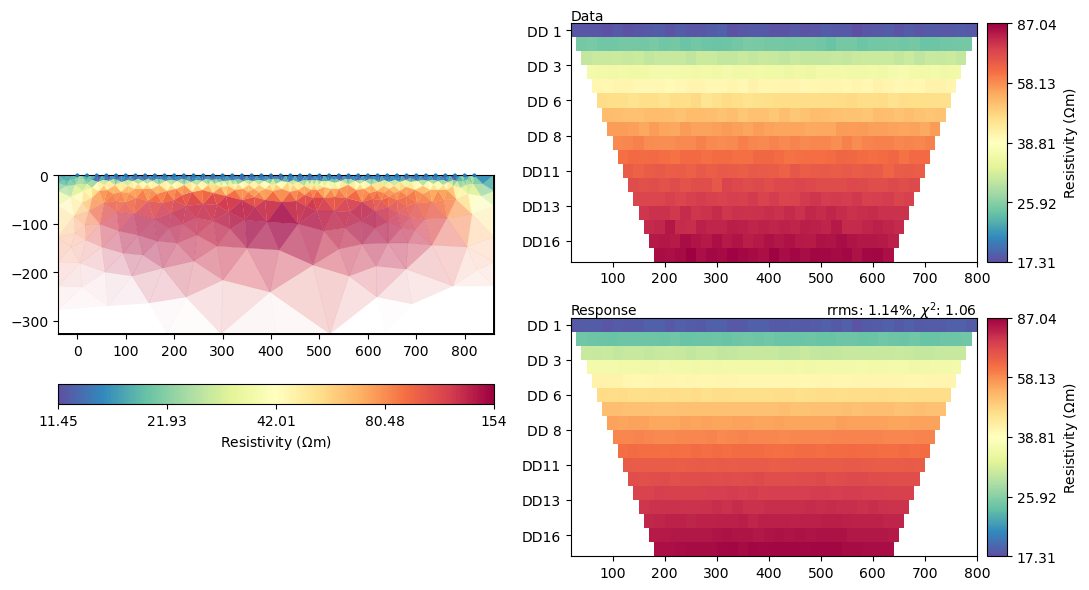

In [23]:
mgr = ert.ERTManager(fwddata);

inv = mgr.invert(lam=20, verbose=True);
# np.testing.assert_approx_equal(mgr.inv.chi2(), 0.7, significant=1) # Not sure what this does, taken from pyGimli example

# plot inversion result with input/output pseudosections
mgr.showResultAndFit();

# plot just inversion result with fixed axis limits
# ax, _ = mgr.showResult(xlabel="x (m)", ylabel="z (m)", cMap="Spectral_r")
# ax.set_xlim(-10,110)

## Inversion with layer boundaries

If we have confidence on the depth of layer interfaces, we can include them in the definition of a mesh for the inversion,
with dramatic results.

Create a similar 'world' with two horizontal lines:

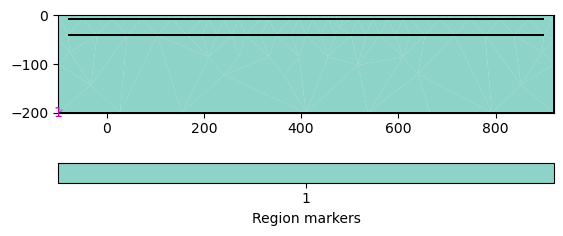

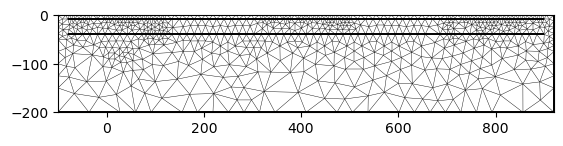

In [24]:
geo = mt.createWorld(start=[min(elecs)-5*spacing, 0.], 
                     end=[max(elecs)+5*spacing, -10*spacing],
                     worldMarker=True)
line1 = pg.meshtools.createLine(start=[min(elecs)-4*spacing, -0.4*spacing],
                                end=[max(elecs)+4*spacing, -0.4*spacing],
                                marker=2) # marker>0 means it functions as a constraint
line2 = pg.meshtools.createLine(start=[min(elecs)-4*spacing, -2*spacing],
                                end=[max(elecs)+4*spacing, -2*spacing],
                                marker=3) # marker>0 means it functions as a constraint

geo += line1 + line2

pg.show(geo)

invmesh = pg.meshtools.createMesh(geo, quality=34, size=1.)
ax, _ = pg.show(invmesh)
#ax.set_xlim(min(elecs)-5*spacing, max(elecs)+5*spacing);
#ax.set_ylim(-10*spacing, 0);

Now re-run the inversion and display...

12/06/24 - 17:43:10 - pyGIMLi - INFO - Found 1 regions.
12/06/24 - 17:43:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
12/06/24 - 17:43:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
12/06/24 - 17:43:10 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 2772 Cells: 5252 Boundaries: 4084
12/06/24 - 17:43:10 - pyGIMLi - INFO - Use median(data values)=54.913818253728984
12/06/24 - 17:43:10 - pyGIMLi - INFO - Created startmodel from forward operator: 1313, min/max=54.913818/54.913818
12/06/24 - 17:43:10 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000222D1417150>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x00000222D1416F70>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000222D1417AB0>
min/max (data): 17.31/87.04
min/max (error): 1%/1.44%
min/max (start model): 54.91/54.91
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 2162.81
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =  292.78 (dPhi = 86.46%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   74.84 (dPhi = 74.42%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    0.99 (dPhi = 98.60%) lam: 20.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.99)   

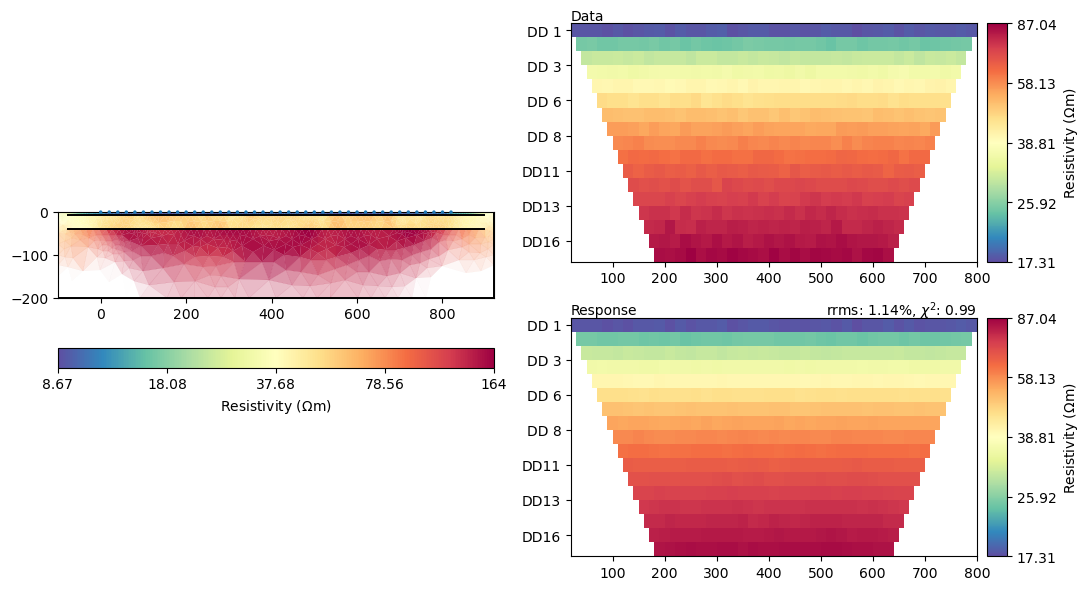

In [25]:
mgrConstrained = ert.ERTManager(fwddata)
coninv = mgrConstrained.invert(verbose=True, lam=20, mesh=invmesh)

mgrConstrained.showResultAndFit();

Finally, we can display both versions of the inversion, with the original 'world' for comparison

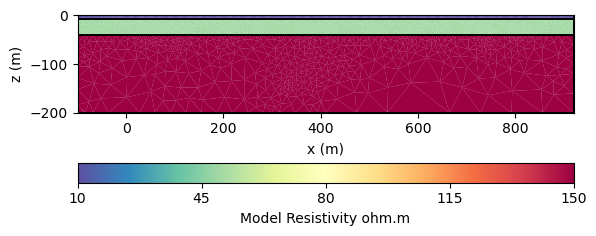

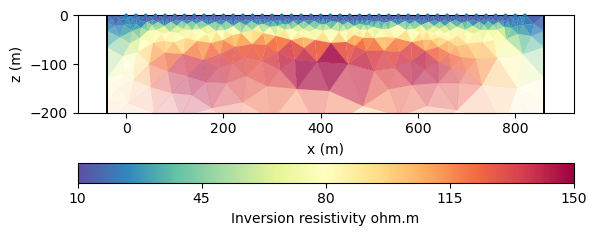

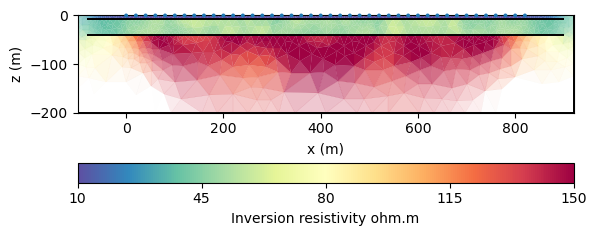

In [26]:
kwargs = {'xlabel':"x (m)", 'ylabel':"z (m)", 'cMap':"Spectral_r", 'cMin':10, 'cMax':150, 'logScale':False}

ax, _ = pg.show(mesh, data=rhomap, showMesh=False, label="Model Resistivity ohm.m", **kwargs)
ax.set_xlim(min(elecs)-5*spacing, max(elecs)+5*spacing);
ax.set_ylim(-10*spacing, 0);

ax, _ = mgr.showResult(label="Inversion resistivity ohm.m",**kwargs)
ax.set_xlim(min(elecs)-5*spacing, max(elecs)+5*spacing);
ax.set_ylim(-10*spacing, 0);

ax, _ = mgrConstrained.showResult(label="Inversion resistivity ohm.m",**kwargs)
ax.set_xlim(min(elecs)-5*spacing, max(elecs)+5*spacing);
ax.set_ylim(-10*spacing, 0);